## Simulation of Murdock and Okada (1970)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the dataset reported by @murdock1970interresponse. Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset presents the opportunity to compare model performance under simplified conditions. Since items' feature representations are assumed orthogonal under considered variants of CMR, retrieving a pattern of contextual associations given an item-based cue only requires abstraction over the cued item's pre-experimental and single experimental contextual associations. Interpretation of apparent differences in performance across model variants thus focus primarily on mechanisms for context-based item representation retrieval.

In [1]:
#| code-summary: code -- load dependencies and data

from compmemlearn.fitting import murdock_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR, Instance_CMR
from compmemlearn.datasets import prepare_murdock1970_data, simulate_data
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('mo1970.txt')

We compared the original prototype-based implementation of CMR against our novel instance-based implementation. First we evaluated each model variant based on their ability to predict the specific sequences of recalls exhibited by each participant. Considering all 20 trials performed by each participant in the dataset, we applied the differential evolution optimization technique to find for each model the parameter configuration that maximized the likelihood of recorded recall sequences. We obtained a unique optimal parameter configuration for each unique participant and each considered model variant. To measure the goodness-of-fit for each parameter configuration and corresponding model, [Figure @fig-MurdOkaFits] plots the log-likelihood of each participant's recall sequences given each model variant's corresponding optimized parameter configuration. The distribution of log-likelihood scores between participants for the PrototypeCMR and InstanceCMR model variants only marginally differ, suggesting little meaningful difference between variants in their effectiveness accounting for participant recall performance across the dataset.

In [2]:
#| output: false
#| code-summary: code -- 1) fit PrototypeCMR participant-by-participant

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count]]), 
        List([murd_length0]),
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=False))
    print(cmr_results[-1].fun)

0 0
288.99862094502595
1 20
239.13119822488508
2 40
328.20175287297013
3 60
339.0395962157854
4 80
324.9184669374846
5 100
307.50205315787036
6 120
262.5031408283206
7 140
287.33998843061886
8 160
232.8886313170959
9 180
349.5016192005342
10 200
184.76488386964607
11 220
314.9111648461321
12 240
367.76275922729644
13 260
269.1168032862765
14 280
286.22865219796165
15 300
336.5731893330593
16 320
311.36751606328403
17 340
283.43109665071626
18 360
390.4438982726467
19 380
384.3899806285
20 400
312.4450556617016
21 420
319.4520526603617
22 440
384.13012780626303
23 460
297.7279642286041
24 480
268.51912675961165
25 500
372.37702115585506
26 520
327.02290844320316
27 540
290.39155745673713
28 560
346.96817816017733
29 580
300.0811907945588
30 600
336.03258219347003
31 620
302.8806935076989
32 640
336.6292132781764
33 660
381.22969615060214
34 680
309.7259309888022
35 700
386.12205022001194
36 720
291.6420855131511
37 740
296.4882927804162
38 760
237.73151336470804
39 780
233.5269339571551

In [4]:
#| output: false
#| code-summary: code -- 2) fit InstanceCMR participant-by-participant

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
    'delay_drift_rate',
)

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count]]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

    icmr_results.append(differential_evolution(cost_function, icmr_bounds, disp=False))
    print(icmr_results[-1].fun)

0 0
282.4640508376864
1 20
236.8659920907519
2 40
326.9573313117923
3 60
340.2407902083119
4 80
322.2761449718833
5 100
300.9124119659814
6 120
258.75378199115914
7 140
288.0839563145306
8 160
231.79217229904918
9 180
352.26359833573446
10 200
186.30856785286375
11 220
317.9908827201739
12 240
372.566944022771
13 260
270.770219345404
14 280
289.47268992915144
15 300
335.22293342872626
16 320
310.8973810087964
17 340
287.2877717063687
18 360
387.68725392247586
19 380
384.2053944810565
20 400
335.35386589875515
21 420
316.70002927510046
22 440
383.91424059629685
23 460
298.39054325480635
24 480
266.63325552748336
25 500
368.16039926977663
26 520
324.9823854122305
27 540
297.9041045765214
28 560
350.96792449195055
29 580
303.887083837236
30 600
343.8062681211182
31 620
309.4671092684352
32 640
334.76384021284036
33 660
380.21999003358474
34 680
312.133139794284
35 700
387.7418981316365
36 720
294.7449042259431
37 740
298.31874173413183
38 760
239.41170231522307
39 780
235.40985287302271
4

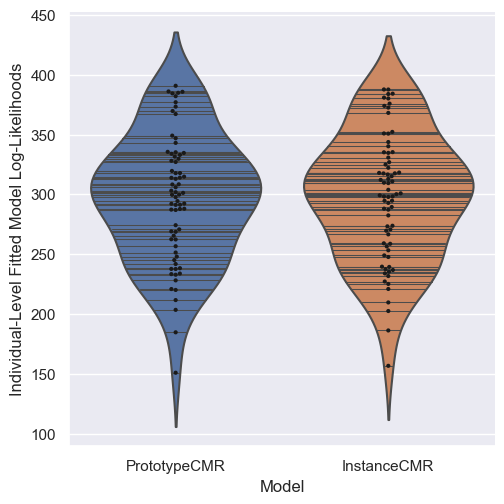

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects
plt.style.use('default')

individual_fits = [result.fun for result in cmr_results] + [result.fun for result in icmr_results]
labels = ['PrototypeCMR'] * len(cmr_results) + ['InstanceCMR'] * len(icmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_murdock1970.pdf', bbox_inches="tight")

summary_table = pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown()

In [14]:
#| output: false
print(summary_table)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |       72      |        72      |
| mean  |      297.128  |       296.249  |
| std   |       52.7989 |        52.8859 |
| min   |      156.753  |       150.988  |
| 25%   |      258.206  |       260.956  |
| 50%   |      299.741  |       299.763  |
| 75%   |      331.797  |       331.946  |
| max   |      387.742  |       390.806  |


::: {#fig-murdokafits layout-nrow=2 layout-valign="center"}

![](individual_murdock1970.pdf)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |        72     |         72     |
| mean  |      297.128   |       296.249  |
| std   |       52.7989 |        52.8859 |
| min   |      156.753 |        150.988 |
| 25%   |     258.206  |       260.956  |
| 50%   |     299.741  |       299.763  |
| 75%   |      331.797  |       331.946  |
| max   |     387.742  |       390.806  |

Distribution of log-likelihood scores of recall sequences exhibited by each subject under each considered model across list-lengths [@murdock1970interresponse]
:::



As a follow-up, we also compared how readily each model could account for organizational summary statistics in the dataset. We found for each model variant the optimal parameter configuration maximizing the likelihood of the entire dataset rather than participant-by-participant. Using each fitted model variant, we simulated 1000 unique free recall trials and measured summary statistics from the result. [Figure @fig-MurdOkaSummary] plots for each model against the corresponding statistics collected over the dataset how recall probability varies as a function of serial position, how the probability of recalling an item first varies as a function of serial position, and how the conditional recall probabability of an item varies as a function of its serial lag from the previously recalled item. Recapitulating our comparison of log-likelihood distributions fitted over discrete participants, we found that both our prototype-based and instance-based CMR implementations account for these benchmark organizational summary statistics across the full dataset to similar extents. To build on this finding of broad model equivalence with respect to the results reported by @murdock1970interresponse, we consider the model variants under broader experimental conditions.

In [7]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 32287.6
differential_evolution step 2: f(x)= 32287.6
differential_evolution step 3: f(x)= 32287.6
differential_evolution step 4: f(x)= 27868.6
differential_evolution step 5: f(x)= 25411.4
differential_evolution step 6: f(x)= 25411.4
differential_evolution step 7: f(x)= 25411.4
differential_evolution step 8: f(x)= 25316.8
differential_evolution step 9: f(x)= 24803.2
differential_evolution step 10: f(x)= 23888.5
differential_evolution step 11: f(x)= 23888.5
differential_evolution step 12: f(x)= 23888.5
differential_evolution step 13: f(x)= 23888.5
differential_evolution step 14: f(x)= 23888.5
differential_evolution step 15: f(x)= 23888.5
differential_evolution step 16: f(x)= 23347.9
differential_evolution step 17: f(x)= 23347.9
differential_evolution step 18: f(x)= 23347.9
differential_evolution step 19: f(x)= 23347.9
differential_evolution step 20: f(x)= 23347.9
differential_evolution step 21: f(x)= 23347.9
differential_evolution step 22: f(x)= 23347

In [8]:
#| include: false
print(cmr_result)

     fun: 22719.877337046357
     jac: array([ 2.50511219, 15.32062015,  0.24592737, -1.49957486, -2.98932717,
       -7.04421837,  0.02364686,  0.        , -9.36888682, -1.96669134,
       -0.94369162,  7.77254168])
 message: 'Optimization terminated successfully.'
    nfev: 8261
     nit: 35
 success: True
       x: array([5.79524319e-01, 4.07083020e-03, 7.24717634e-01, 7.47425733e-01,
       1.00000000e+00, 9.58358158e-02, 9.55947397e+00, 8.71434638e+01,
       3.13827247e-02, 3.36754300e-01, 9.25336064e+00, 9.95710836e-01])


In [9]:
#| output: false
#| code-summary: code -- 2) fit Instance_CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

icmr_result = differential_evolution(cost_function, icmr_bounds, disp=True)

differential_evolution step 1: f(x)= 26548.1
differential_evolution step 2: f(x)= 26548.1
differential_evolution step 3: f(x)= 26548.1
differential_evolution step 4: f(x)= 26548.1
differential_evolution step 5: f(x)= 26548.1
differential_evolution step 6: f(x)= 26548.1
differential_evolution step 7: f(x)= 26548.1
differential_evolution step 8: f(x)= 26548.1
differential_evolution step 9: f(x)= 26548.1
differential_evolution step 10: f(x)= 26548.1
differential_evolution step 11: f(x)= 26033.3
differential_evolution step 12: f(x)= 26033.3
differential_evolution step 13: f(x)= 26033.3
differential_evolution step 14: f(x)= 26033.3
differential_evolution step 15: f(x)= 25720.8
differential_evolution step 16: f(x)= 25720.8
differential_evolution step 17: f(x)= 25720.8
differential_evolution step 18: f(x)= 25720.8
differential_evolution step 19: f(x)= 24932.7
differential_evolution step 20: f(x)= 24618
differential_evolution step 21: f(x)= 24618
differential_evolution step 22: f(x)= 24618
dif

In [10]:
#| include: false
print(icmr_result)

     fun: 22742.53782739334
     jac: array([ -2.0409061 ,   5.60794433,   0.86656655,  17.60818122,
       -11.07546262,   0.34633558,  -0.04511094,   0.        ,
       -12.56958057,  -4.26807674,  -0.71559044,   5.453694  ])
 message: 'Optimization terminated successfully.'
    nfev: 15288
     nit: 64
 success: True
       x: array([7.29095772e-01, 2.92067837e-03, 8.26297120e-01, 7.79445763e-03,
       1.00000000e+00, 2.01411834e-01, 7.34142938e+00, 2.04767095e+01,
       3.83526165e-02, 2.94499609e-01, 1.46955441e+00, 9.93393279e-01])


In [11]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(icmr_result.x)):
    fitted_parameters[icmr_free_parameters[i]] = icmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['choice_sensitivity'] = 1
fitted_parameters['feature_sensitivity'] = 1

model = Instance_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
icmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['InstanceCMR', 'data'])
icmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr = icmr_pfr.query('output <= 1')

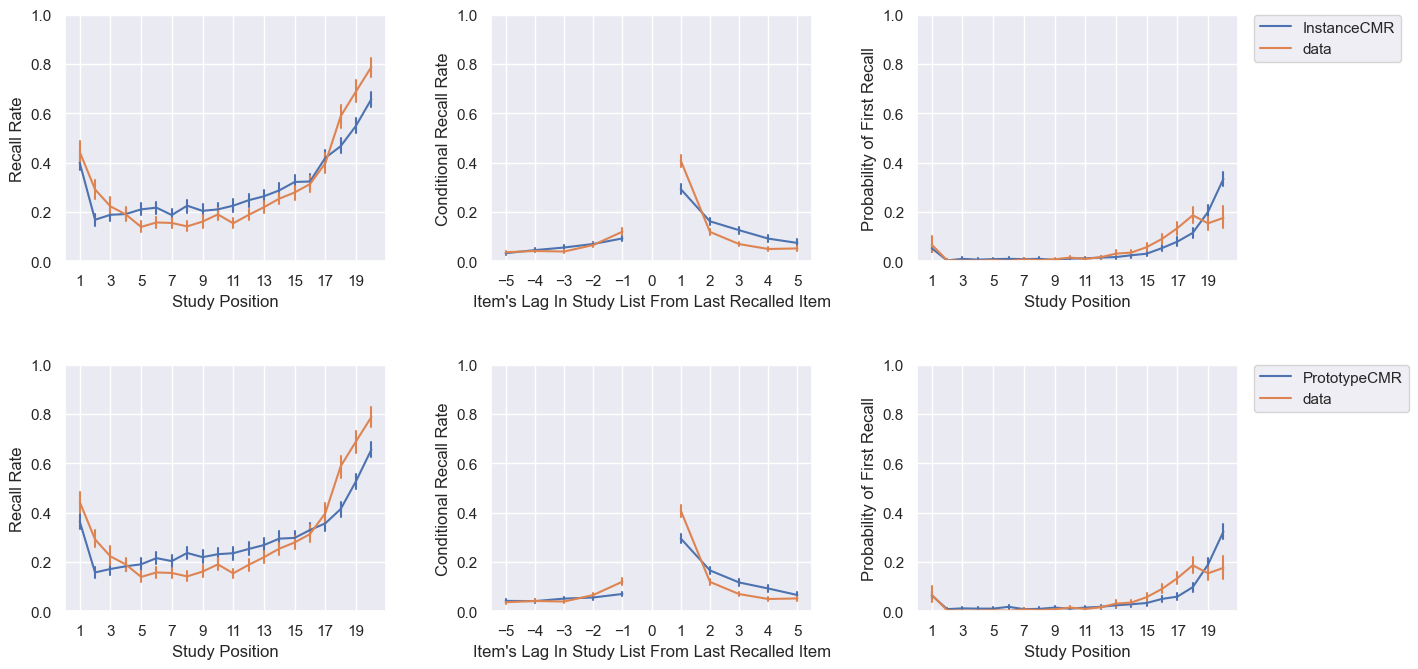

In [12]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

import matplotlib.pyplot as plt

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15/2), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, 21, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[1, 0].set_xticks(np.arange(1, 21, 2))
axes[1, 0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[0, 1].set_xticks(np.arange(-5, 6, 1))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr, x='input', y='prob', err_style='bars', ax=axes[0, 2], hue='source')
axes[0, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[0, 2].set_xticks(np.arange(1, 21, 2))
axes[0, 2].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[1, 2], hue='source')
axes[1, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[1, 2].set_xticks(np.arange(1, 21, 2))
axes[1, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

![Comparison of summary statistics between each model against observed data [@murdock1970interresponse]](overall_murdock1970.pdf){#fig-murdokasummary}